In [1]:
# 1. Install necessary library
!pip install google-play-scraper tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google_play_scraper import Sort, reviews

# Define target apps (Entertainment Category)
app_packages = [
    'com.netflix.mediaclient',
    'com.disney.disneyplus',
    'com.amazon.avod.thirdpartyclient',
    'com.spotify.music',
    'tv.twitch.android.app'
]

all_data = []

print("Starting Data Collection (Scraping)...")

# Scrape reviews
for app in app_packages:
    try:
        result, continuation_token = reviews(
            app,
            lang='tr', country='tr', sort=Sort.NEWEST, count=600
        )
        for r in result:
            all_data.append({
                'review': r['content'],
                'rating': r['score'],
                'app_name': app
            })
        print(f"Fetched {len(result)} reviews from: {app}")
    except Exception as e:
        print(f"Error fetching {app}: {e}")

df = pd.DataFrame(all_data)

# Labeling: 4-5 Positive, 1-2 Negative, 3 Neutral (Dropped)
def label_sentiment(rating):
    if rating >= 4: return 'Positive'
    elif rating <= 2: return 'Negative'
    else: return 'Neutral'

df['sentiment'] = df['rating'].apply(label_sentiment)
df = df[df['sentiment'] != 'Neutral'] # Binary classification constraint

# Save to CSV
df.to_csv('streaming_reviews_final.csv', index=False)

print("-" * 30)
print(f"Total Cleaned Samples: {len(df)}") # Raporda bu sayıyı belirt
print("Class Distribution:\n", df['sentiment'].value_counts())
print("-" * 30)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
Starting Data Collection (Scraping)...
Fetched 600 reviews from: com.netflix.mediaclient
Fetched 600 reviews from: com.disney.disneyplus
Fetched 600 reviews from: com.amazon.avod.thirdpartyclient
Fetched 600 reviews from: com.spotify.music
Fetched 600 reviews from: tv.twitch.android.app
------------------------------
Total Cleaned Samples: 2810
Class Distribution:
 sentiment
Negative    1540
Positive    1270
Name: count, dtype: int64
------------------------------


In [3]:
# 1. Önce Türkçe Stemmer kütüphanesini indirelim
!pip install TurkishStemmer

import re
import nltk
from nltk.corpus import stopwords
from TurkishStemmer import TurkishStemmer # Yeni kütüphane
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Gerekli NLTK paketleri
nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

# Stemmer'ı başlatalım
stemmer = TurkishStemmer()

def clean_text(text):
    # 1. Küçük harfe çevir
    text = text.lower()
    # 2. Noktalama işaretleri ve sayıları kaldır
    text = re.sub(r'[^a-zA-ZçğıöşüÇĞİÖŞÜ\s]', '', text)
    # 3. Boşlukları temizle
    text = text.strip()
    # 4. Kelimelere ayır
    words = text.split()

    # 5. Stopwords temizliği ve Stemming (Kök bulma)
    # Not: TurkishStemmer bazen kelimeyi köküne kadar indirir (örn: "geliyorum" -> "gel")
    clean_words = []
    for w in words:
        if w not in turkish_stopwords:
            try:
                # Stemmer bazen hata verebilir, try-except ile koruyalım
                root = stemmer.stem(w)
                clean_words.append(root)
            except:
                clean_words.append(w)

    return " ".join(clean_words)

print("Applying Preprocessing (Normalization + Stopwords + Stemming)...")

# Eğer HÜCRE 1'i çalıştırdıysan 'df' hafızadadır.
# Eğer hata aldıysan ve df kaybolduysa önce Hücre 1'i tekrar çalıştır.
if 'df' in locals():
    df['clean_review'] = df['review'].apply(clean_text)
    # Boş kalanları at
    df = df[df['clean_review'] != ""]

    # Veriyi Böl (Train/Test)
    X = df['clean_review']
    y = df['sentiment'].map({'Positive': 1, 'Negative': 0})

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Vektörleştirme (TF-IDF)
    tfidf = TfidfVectorizer(max_features=2000)
    X_train_vec = tfidf.fit_transform(X_train).toarray()
    X_test_vec = tfidf.transform(X_test).toarray()

    print(f"Training Data: {len(X_train)} | Test Data: {len(X_test)}")
    print("Preprocessing Done. (TurkishStemmer başarıyla kullanıldı)")
else:
    print("HATA: 'df' bulunamadı. Lütfen önce 1. Hücreyi (Data Collection) çalıştırın.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Applying Preprocessing (Normalization + Stopwords + Stemming)...
Training Data: 2224 | Test Data: 557
Preprocessing Done. (TurkishStemmer başarıyla kullanıldı)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Dictionary to save models
models_dict = {}

# 1. Logistic Regression (with GridSearch for Regularization)
print("Training Logistic Regression (with Tuning)...")
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_lr.fit(X_train_vec, y_train)
models_dict['Logistic Regression'] = grid_lr.best_estimator_
print(f"Best C parameter: {grid_lr.best_params_['C']}")

# 2. Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vec, y_train)
models_dict['Random Forest'] = rf

# 3. SVM
print("Training SVM...")
svm = SVC(kernel='linear', probability=True, random_state=42) # Probability=True for ROC-AUC
svm.fit(X_train_vec, y_train)
models_dict['SVM'] = svm

print("Traditional Models Trained.")

Training Logistic Regression (with Tuning)...
Best C parameter: 1
Training Random Forest...
Training SVM...
Traditional Models Trained.


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print("Training Deep Learning Model (Keras MLP)...")

# Define Architecture
model_dl = Sequential()
model_dl.add(Dense(64, input_dim=2000, activation='relu'))
model_dl.add(Dropout(0.5)) # Overfitting Technique 1: Dropout
model_dl.add(Dense(32, activation='relu'))
model_dl.add(Dropout(0.5))
model_dl.add(Dense(1, activation='sigmoid')) # Binary Output

# Compile
model_dl.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Overfitting Technique 2: Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history = model_dl.fit(
    X_train_vec, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

print("Deep Learning Training Complete.")

Training Deep Learning Model (Keras MLP)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5345 - loss: 0.6871 - val_accuracy: 0.5605 - val_loss: 0.6503
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6289 - loss: 0.6308 - val_accuracy: 0.7354 - val_loss: 0.5212
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8275 - loss: 0.4640 - val_accuracy: 0.8834 - val_loss: 0.3641
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8797 - loss: 0.3208 - val_accuracy: 0.8924 - val_loss: 0.3260
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9285 - loss: 0.2284 - val_accuracy: 0.8834 - val_loss: 0.3275
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9364 - loss: 0.1902 - val_accuracy: 0.8700 - val_loss: 0.3441
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9617 - loss: 0.1434 - val_accuracy: 0.8700 - val_loss: 0.3670
Deep Learning Training Complete.


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results_detailed = []

# Evaluate Traditional Models
for name, model in models_dict.items():
    y_pred = model.predict(X_test_vec)
    y_prob = model.predict_proba(X_test_vec)[:, 1]

    results_detailed.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

# Evaluate Deep Learning Model
y_pred_dl_prob = model_dl.predict(X_test_vec).flatten()
y_pred_dl = (y_pred_dl_prob > 0.5).astype(int)

results_detailed.append({
    "Model": "Deep Learning (Keras)",
    "Accuracy": accuracy_score(y_test, y_pred_dl),
    "Precision": precision_score(y_test, y_pred_dl),
    "Recall": recall_score(y_test, y_pred_dl),
    "F1-Score": f1_score(y_test, y_pred_dl),
    "ROC-AUC": roc_auc_score(y_test, y_pred_dl_prob)
})

# Display Results
results_df = pd.DataFrame(results_detailed).sort_values(by='F1-Score', ascending=False)
print("\n" + "="*50)
print("FINAL MODEL COMPARISON TABLE")
print("="*50)
print(results_df)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

FINAL MODEL COMPARISON TABLE
                   Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
3  Deep Learning (Keras)  0.827648   0.809524  0.782427  0.795745  0.892259
1          Random Forest  0.811490   0.799107  0.748954  0.773218  0.880214
2                    SVM  0.818671   0.845000  0.707113  0.769932  0.890667
0    Logistic Regression  0.820467   0.879781  0.673640  0.763033  0.894641


Generating Learning Curve...


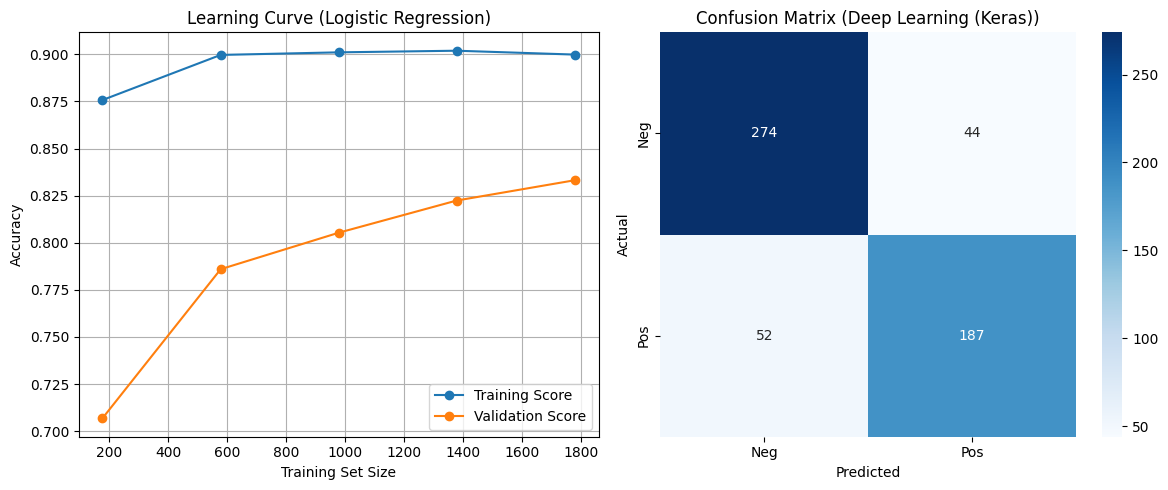

Project Completed Successfully!


In [7]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix

# 1. Plot Learning Curve (for Logistic Regression)
print("Generating Learning Curve...")
train_sizes, train_scores, test_scores = learning_curve(
    models_dict['Logistic Regression'], X_train_vec, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Validation Score')
plt.title('Learning Curve (Logistic Regression)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# 2. Plot Confusion Matrix (for Best Model - usually LR)
best_model_name = results_df.iloc[0]['Model']
if best_model_name == "Deep Learning (Keras)":
    y_final_pred = y_pred_dl
else:
    y_final_pred = models_dict[best_model_name].predict(X_test_vec)

cm = confusion_matrix(y_test, y_final_pred)
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.title(f'Confusion Matrix ({best_model_name})')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

print("Project Completed Successfully!")